## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [2]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
from sklearn import preprocessing

In [33]:
from keras.layers import Dropout

In [34]:
from keras.regularizers import l1, l2, l1_l2

In [40]:
from keras.layers import BatchNormalization

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [17]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [18]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [61]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256,128,64],drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [62]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-2
EPOCHS = 100
DROPOUT=0.2
BATCH_SIZE=512
MOMENTUM = 0.95
EARLY_MONITOR=[10,25]

# Call Back 
monitor: 被监测的数据。

min_delta: 在被监测的数据中被认为是提升的最小变化， 例如，小于 min_delta 的绝对变化会被认为没有提升。

patience: 没有进步的训练轮数，在这之后训练就会被停止。

verbose: 详细信息模式。

mode: {auto, min, max} 其中之一。 在 min 模式中， 当被监测的数据停止下降，训练就会停止；在 max 模式中，当被监测的数据停止上升，训练就会停止；在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。

baseline: 要监控的数量的基准值。 如果模型没有显示基准的改善，训练将停止。

restore_best_weights: 是否从具有监测数量的最佳值的时期恢复模型权重。 如果为 False，则使用在训练的最后一步获得的模型权重。

In [63]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping


results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for early_monitor in EARLY_MONITOR:
    #設定 callbacks: Earlystop
    earlystop = EarlyStopping(monitor="val_accuracy", patience=early_monitor, 
                              verbose=1
                              )
#Early stopping conditioned. Available metrics are:     val_loss,
                                                        #val_accuracy,
                                                        #loss,
                                                        #accuracy
                          
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Early_Monitor = %.6f" % (early_monitor))
    model = build_mlp(input_shape=x_train.shape[1:],drop_ratio=DROPOUT)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train,
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE, 
                          validation_data=(x_test, y_test), 
                          shuffle=True,
                     callbacks=[earlystop])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
             
    exp_name_tag = "Early_Monitor = %s" % str(early_monitor)
    print(exp_name_tag)
    results[exp_name_tag] = {'train-loss': train_loss,
                                         'valid-loss': valid_loss,
                                         'train-acc': train_acc,
                                         'valid-acc': valid_acc}

Experiment with Early_Monitor = 10.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropou

50000/50000 [==============================] - 6s 112us/step - loss: 0.8814 - accuracy: 0.6866 - val_loss: 1.3123 - val_accuracy: 0.5564
Epoch 44/100
50000/50000 [==============================] - 6s 127us/step - loss: 0.8773 - accuracy: 0.6869 - val_loss: 1.2971 - val_accuracy: 0.5637
Epoch 45/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.8639 - accuracy: 0.6923 - val_loss: 1.3240 - val_accuracy: 0.5567
Epoch 46/100
50000/50000 [==============================] - 6s 113us/step - loss: 0.8626 - accuracy: 0.6930 - val_loss: 1.3153 - val_accuracy: 0.5564
Epoch 47/100
50000/50000 [==============================] - 5s 107us/step - loss: 0.8513 - accuracy: 0.6991 - val_loss: 1.3244 - val_accuracy: 0.5547
Epoch 48/100
50000/50000 [==============================] - 6s 112us/step - loss: 0.8411 - accuracy: 0.6982 - val_loss: 1.3307 - val_accuracy: 0.5555
Epoch 49/100
50000/50000 [==============================] - 5s 109us/step - loss: 0.8352 - accuracy: 0.7011 - val

Epoch 31/100
50000/50000 [==============================] - 7s 139us/step - loss: 1.0028 - accuracy: 0.6432 - val_loss: 1.2711 - val_accuracy: 0.5605
Epoch 32/100
50000/50000 [==============================] - 7s 137us/step - loss: 0.9818 - accuracy: 0.6492 - val_loss: 1.2775 - val_accuracy: 0.5584
Epoch 33/100
50000/50000 [==============================] - 5s 101us/step - loss: 0.9710 - accuracy: 0.6528 - val_loss: 1.2850 - val_accuracy: 0.5569
Epoch 34/100
50000/50000 [==============================] - 6s 117us/step - loss: 0.9610 - accuracy: 0.6588 - val_loss: 1.2905 - val_accuracy: 0.5594
Epoch 35/100
50000/50000 [==============================] - 5s 105us/step - loss: 0.9590 - accuracy: 0.6576 - val_loss: 1.2801 - val_accuracy: 0.5621
Epoch 36/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.9443 - accuracy: 0.6636 - val_loss: 1.2755 - val_accuracy: 0.5622
Epoch 37/100
50000/50000 [==============================] - 6s 112us/step - loss: 0.9318 - accuracy: 

50000/50000 [==============================] - 7s 143us/step - loss: 0.6191 - accuracy: 0.7818 - val_loss: 1.4925 - val_accuracy: 0.5507
Epoch 00085: early stopping
Early_Monitor = 25


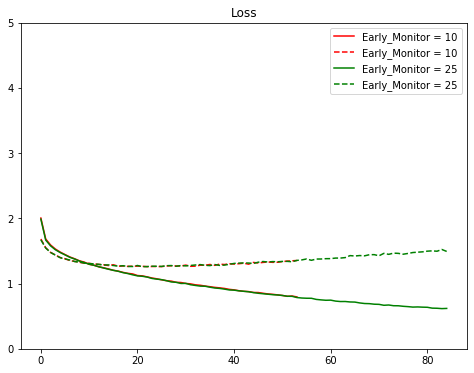

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

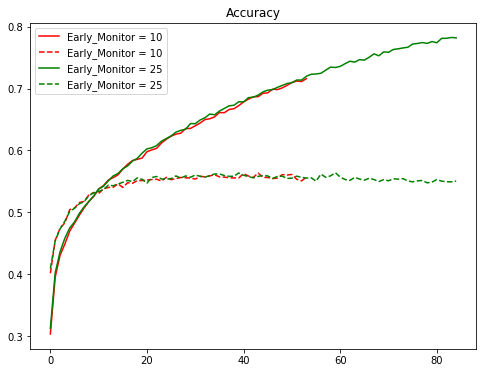

In [65]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()